##### IMPORT LIBRARIES

In [ ]:
# Loading the required data libraries in Python
import re 
import plotly.express as px 
import pandas as pd  
import seaborn as sns 
import datetime as dt  
import numpy as np 
import matplotlib.pyplot as plt  

import pytz #timezone

##### READ DATA

In [ ]:
sm_df = pd.read_feather('data/Active Power/sm.feather')

In [ ]:
sm_df.head()

,TIME [UTC Seconds],R[kW],Y[kW],B[kW],Unnamed: 4
0,1690828200000,1.17,0.64,0.96,NaN
1,1690828800000,1.16,0.73,0.98,NaN
2,1690829400000,1.19,0.72,0.98,NaN
3,1690830000000,1.16,0.73,0.97,NaN
4,1690830600000,1.20,0.74,0.99,NaN


##### DATA PREPARATION

In [ ]:
sm_df.columns

Index(['TIME [UTC Seconds]', 'R[kW]   ', 'Y[kW]   ', 'B[kW]   ', 'Unnamed: 4'], dtype='object')

In [ ]:
sm_df.drop(columns=['Unnamed: 4'],inplace=True)
sm_df.rename(columns={'TIME [UTC Seconds]':'TIME', 'R[kW]   ':'R', 'Y[kW]   ':'Y', 'B[kW]   ':'B'},inplace=True)

In [ ]:
# Convert TIME column to type-Datetime
sm_df['TIME'] = pd.to_datetime(sm_df['TIME'], unit='ms', utc=True)

# Define the IST timezone
ist_timezone = pytz.timezone('Asia/Kolkata')

# Convert the time from UTC to IST
sm_df['TIME'] = sm_df['TIME'].dt.tz_convert(ist_timezone)

In [ ]:
# Remove the timezone information
sm_df['TIME'] = sm_df['TIME'].dt.tz_localize(None)

In [ ]:
sm_df['Active Power'] = sm_df['R']+sm_df['Y']+sm_df['B']

In [ ]:
sm_df.head()

,TIME,R,Y,B,Active Power
0,2023-08-01 00:00:00,1.17,0.64,0.96,2.77
1,2023-08-01 00:10:00,1.16,0.73,0.98,2.87
2,2023-08-01 00:20:00,1.19,0.72,0.98,2.89
3,2023-08-01 00:30:00,1.16,0.73,0.97,2.86
4,2023-08-01 00:40:00,1.20,0.74,0.99,2.93


In [ ]:
print(f'Total length : {len(sm_df)}')
missing_values= sm_df.isnull().sum()
print(missing_values)

Total length : 51796
TIME            0
R               6
Y               6
B               6
Active Power    6
dtype: int64


In [ ]:
sm_df.dropna(inplace=True)

In [ ]:
# Create the new columns
sm_df['Date'] = sm_df['TIME'].dt.date             # Extracting the Date part
sm_df['Hour'] = sm_df['TIME'].dt.hour             # Extracting the Hour
sm_df['Month'] = sm_df['TIME'].dt.month           # Extracting the Month
sm_df['Year'] = sm_df['TIME'].dt.year             # Extracting the Year
sm_df['Weekday'] = sm_df['TIME'].dt.weekday       # 0 = Monday, 6 = Sunday
sm_df['Is_Weekday'] = sm_df['TIME'].dt.weekday.apply(lambda x: 1 if x < 5 else 0)  # 1 for weekday, 0 for weekend

In [ ]:
#We have few days data from 2023 July, so I am removing those
sm_df = sm_df[~((sm_df['Year'] == 2023) & (sm_df['Month'] == 7))]

In [ ]:
sm_df.set_index('TIME',inplace=True)

In [ ]:
sm_df.head()

,R,Y,B,Active Power,Date,Hour,Month,Year,Weekday,Is_Weekday
TIME,,,,,,,,,,
2023-08-01 00:00:00,1.17,0.64,0.96,2.77,2023-08-01,0,8,2023,1,1
2023-08-01 00:10:00,1.16,0.73,0.98,2.87,2023-08-01,0,8,2023,1,1
2023-08-01 00:20:00,1.19,0.72,0.98,2.89,2023-08-01,0,8,2023,1,1
2023-08-01 00:30:00,1.16,0.73,0.97,2.86,2023-08-01,0,8,2023,1,1
2023-08-01 00:40:00,1.20,0.74,0.99,2.93,2023-08-01,0,8,2023,1,1


##### TIMESERIES ANALYSIS

Text(0.5, 1.0, 'Active Power Time Series')

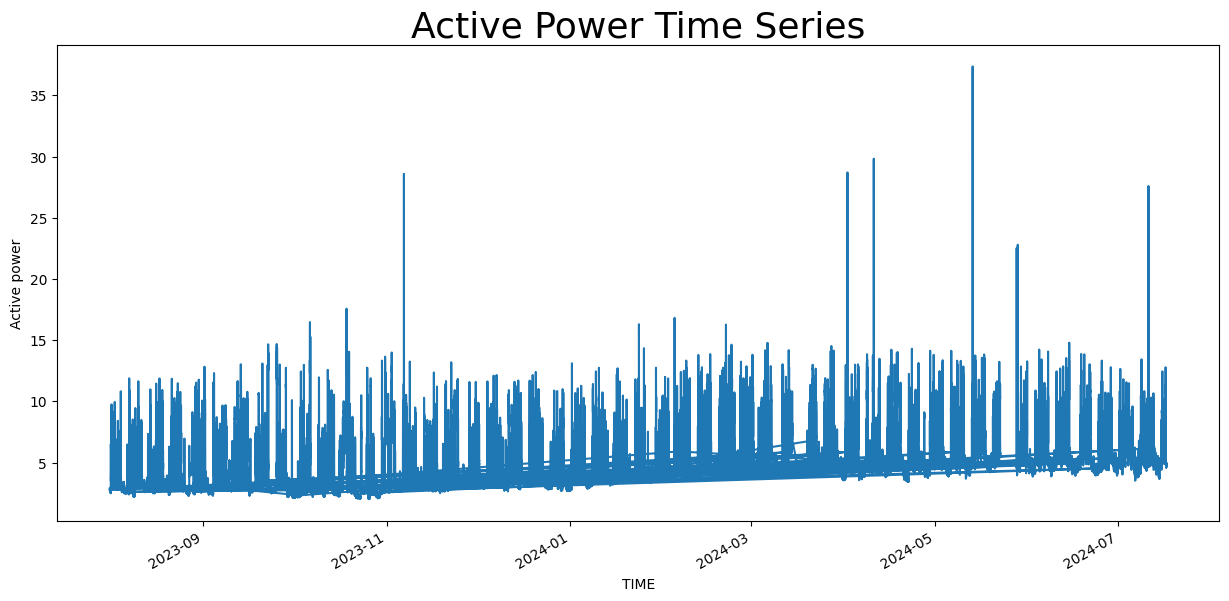

In [ ]:
sm_df['Active Power'].plot(figsize=(15,7),legend=False)
plt.ylabel('Active power')
plt.title('Active Power Time Series',size=26)

BAR-PLOT

In [ ]:
# We can use only numeric columns for resampling
numeric_cols = sm_df.select_dtypes(include=['number']).columns

# Resample the data to daily frequency
daily_data = sm_df[numeric_cols].resample('D').mean()

# Create Year and Month columns from the datetime index
daily_data['Year'] = daily_data.index.year
daily_data['Month'] = daily_data.index.month

daily_data.dropna(inplace=True)

# As the date range in my data is from August 2023 to July 2024:

# Create a 'Year-Month' column to distinguish months across different years
daily_data['Year-Month'] = daily_data.index.to_period('M')

# Group by the 'Year-Month' and calculate the mean active power for each period
monthly_active_power = daily_data.groupby('Year-Month')['Active Power'].mean()

In [ ]:
monthly_active_power

Year-Month
2023-08    3.848887
2023-09    3.771004
2023-10    3.534743
2023-11    4.111237
2023-12    4.095953
2024-01    4.450515
2024-02    5.627645
2024-03    5.889899
2024-04    5.660411
2024-05    5.990938
2024-06    5.591311
2024-07    5.678783
Freq: M, Name: Active Power, dtype: float64

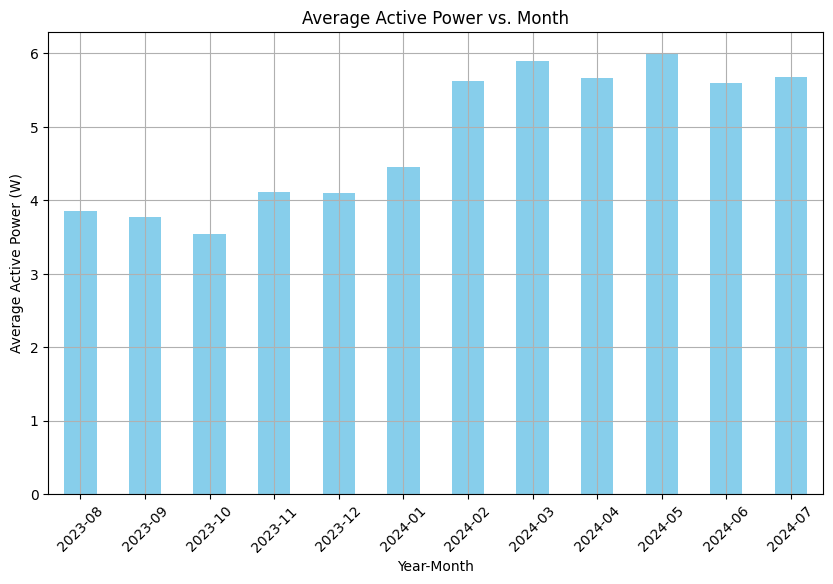

In [ ]:
# Plotting Active Power vs. Month
plt.figure(figsize=(10,6))
monthly_active_power.plot(kind='bar', color='skyblue')
plt.title('Average Active Power vs. Month')
plt.xlabel('Year-Month')
plt.ylabel('Average Active Power (W)')
plt.xticks( rotation=45)
plt.grid(True)
plt.show()

LINE PLOT

C:\Users\sawan\AppData\Local\Temp\ipykernel_17576\1357208834.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.set_xticks(pd.date_range(start='2023-07-31', end='2024-07-17', freq='M'))  # Set ticks at monthly intervals


[Text(19569.0, 0, 'Aug-23'),
 Text(19600.0, 0, 'Sep-23'),
 Text(19630.0, 0, 'Oct-23'),
 Text(19661.0, 0, 'Nov-23'),
 Text(19691.0, 0, 'Dec-23'),
 Text(19722.0, 0, 'Jan-24'),
 Text(19753.0, 0, 'Feb-24'),
 Text(19782.0, 0, 'Mar-24'),
 Text(19813.0, 0, 'Apr-24'),
 Text(19843.0, 0, 'May-24'),
 Text(19874.0, 0, 'Jun-24'),
 Text(19904.0, 0, 'Jul-24')]

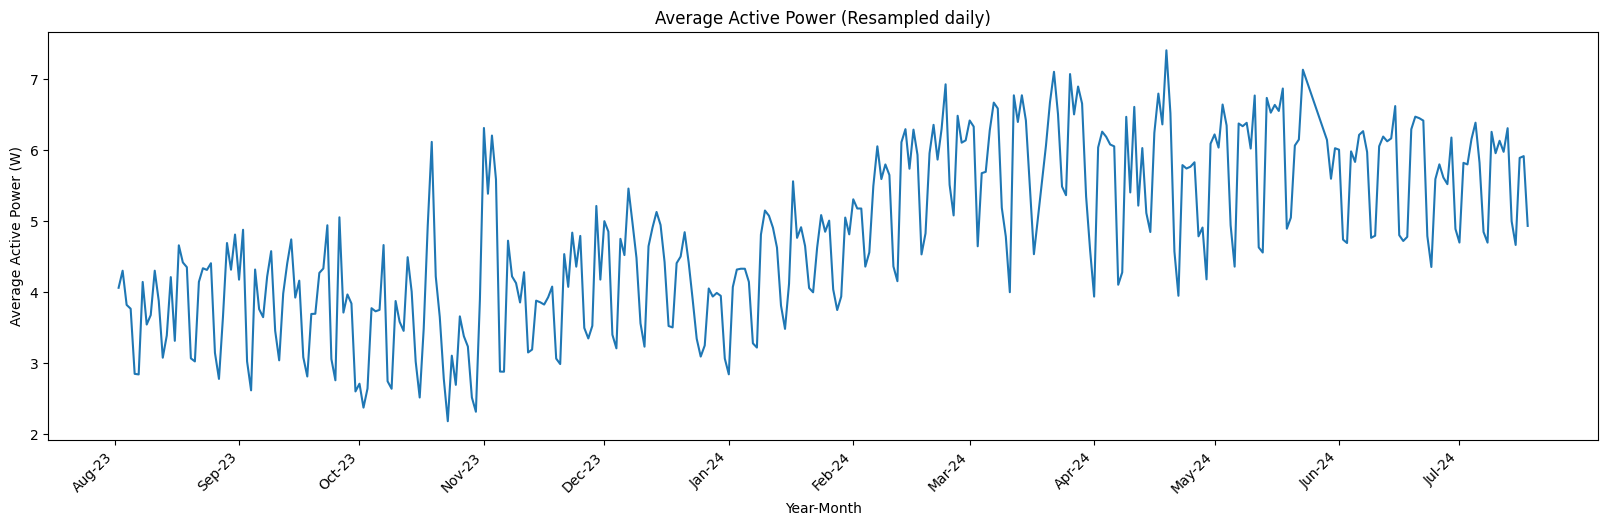

In [ ]:
plt.figure(figsize=(20,6))
daily_data['Active Power'].plot()
plt.title('Average Active Power (Resampled daily)')
plt.xlabel('Year-Month')
plt.ylabel('Average Active Power (W)')
#plt.xticks(ticks=range(12), labels=['Aug-23', 'Sep-23', 'Oct-23', 'Nov-23', 'Dec-23','Jan-23', 'Feb-23', 'Mar-23', 'Apr-23', 'May-23', 'Jun-23', 'Jul-23'], rotation=45)
ax = plt.gca()  # Get current axis
ax.set_xticks(pd.date_range(start='2023-07-31', end='2024-07-17', freq='M'))  # Set ticks at monthly intervals
ax.set_xticklabels(['Aug-23', 'Sep-23', 'Oct-23', 'Nov-23', 'Dec-23', 'Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24', 'Jun-24', 'Jul-24'], rotation=45)

BOXPLOT

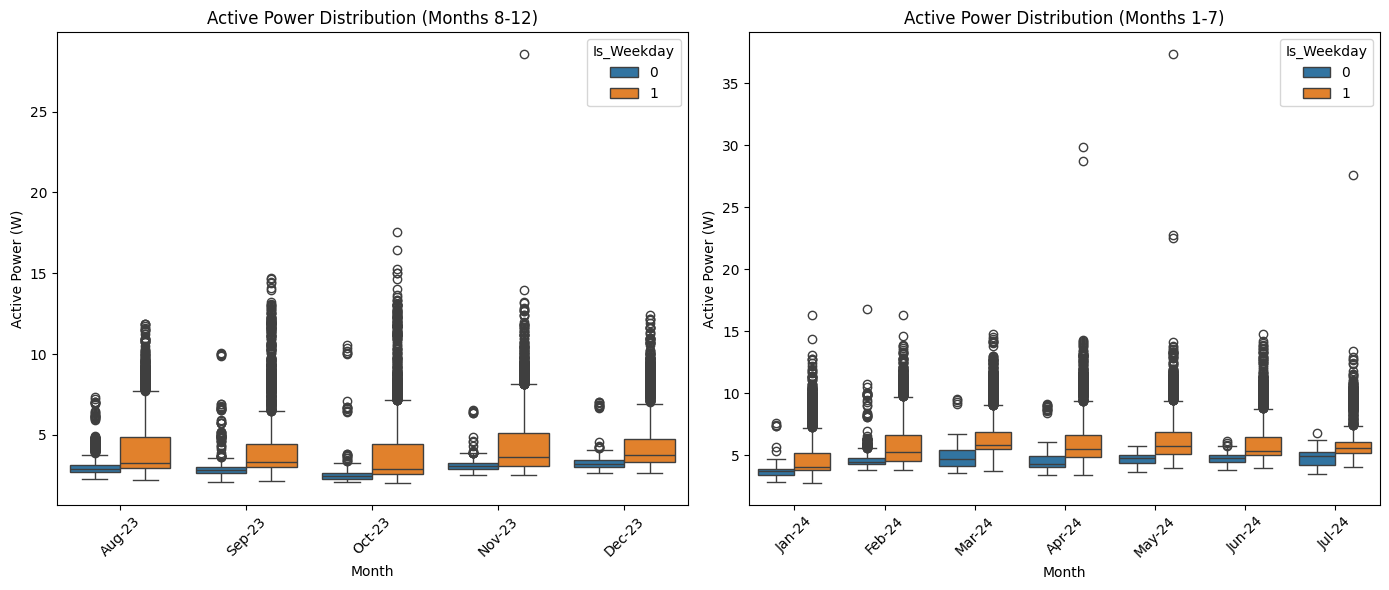

In [ ]:
# Split the data into two DataFrames: one for months 1-7 and one for months 8-12
df_1_7 = sm_df[sm_df['Month'].isin(range(1, 8))]
df_8_12 = sm_df[sm_df['Month'].isin(range(8, 13))]

# Create a figure with two subplots
fig, axes = plt.subplots(1,2, figsize=(14, 6))

# Plot for months 8-12
sns.boxplot(ax=axes[0], x='Month', y='Active Power', hue='Is_Weekday',data=df_8_12)
axes[0].set_title('Active Power Distribution (Months 8-12)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Active Power (W)')

# Custom xticks for months 8-12
months_8_12 = ['Aug-23', 'Sep-23', 'Oct-23', 'Nov-23', 'Dec-23']
axes[0].set_xticks(range(5))
axes[0].set_xticklabels(months_8_12, rotation=45)

# Plot for months 1-7
sns.boxplot(ax=axes[1], x='Month', y='Active Power',hue='Is_Weekday', data=df_1_7)
axes[1].set_title('Active Power Distribution (Months 1-7)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Active Power (W)')

# Custom xticks for months 1-7
months_1_7 = ['Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24', 'Jun-24', 'Jul-24']
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(months_1_7, rotation=45)

# Adjust the layout for better fit
plt.tight_layout()
plt.show()

VIOLIN PLOT

In [ ]:
sm_df['Is_Weekday'].value_counts()

Is_Weekday
1    35726
0    14046
Name: count, dtype: int64

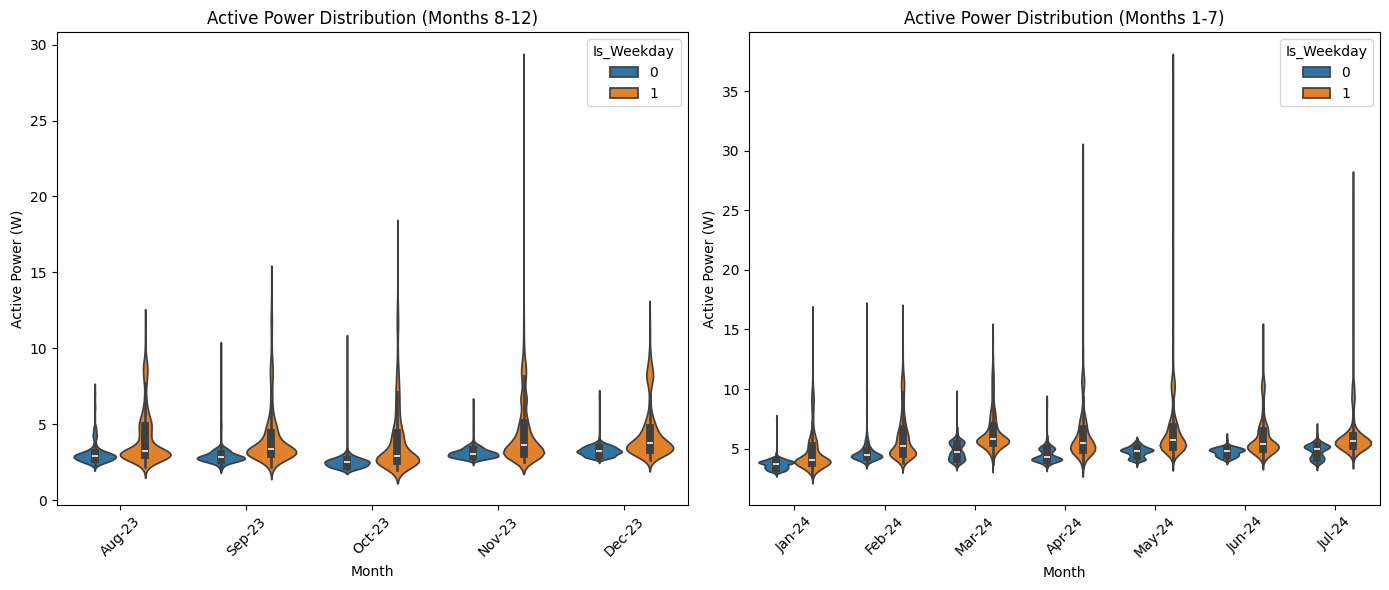

In [ ]:
# Split the data into two DataFrames: one for months 1-7 and one for months 8-12
df_1_7 = sm_df[sm_df['Month'].isin(range(1, 8))]
df_8_12 = sm_df[sm_df['Month'].isin(range(8, 13))]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for months 8-12
sns.violinplot(ax=axes[0], x='Month', y='Active Power',hue='Is_Weekday', data=df_8_12)
axes[0].set_title('Active Power Distribution (Months 8-12)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Active Power (W)')

# Custom xticks for months 8-12
months_8_12 = ['Aug-23', 'Sep-23', 'Oct-23', 'Nov-23', 'Dec-23']
axes[0].set_xticks(range(5))
axes[0].set_xticklabels(months_8_12, rotation=45)

# Plot for months 1-7
sns.violinplot(ax=axes[1], x='Month', y='Active Power', hue='Is_Weekday', data=df_1_7)
axes[1].set_title('Active Power Distribution (Months 1-7)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Active Power (W)')

# Custom xticks for months 1-7
months_1_7 = ['Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24', 'Jun-24', 'Jul-24']
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(months_1_7, rotation=45)

# Adjust the layout for better fit
plt.tight_layout()
plt.show()

HEATMAP

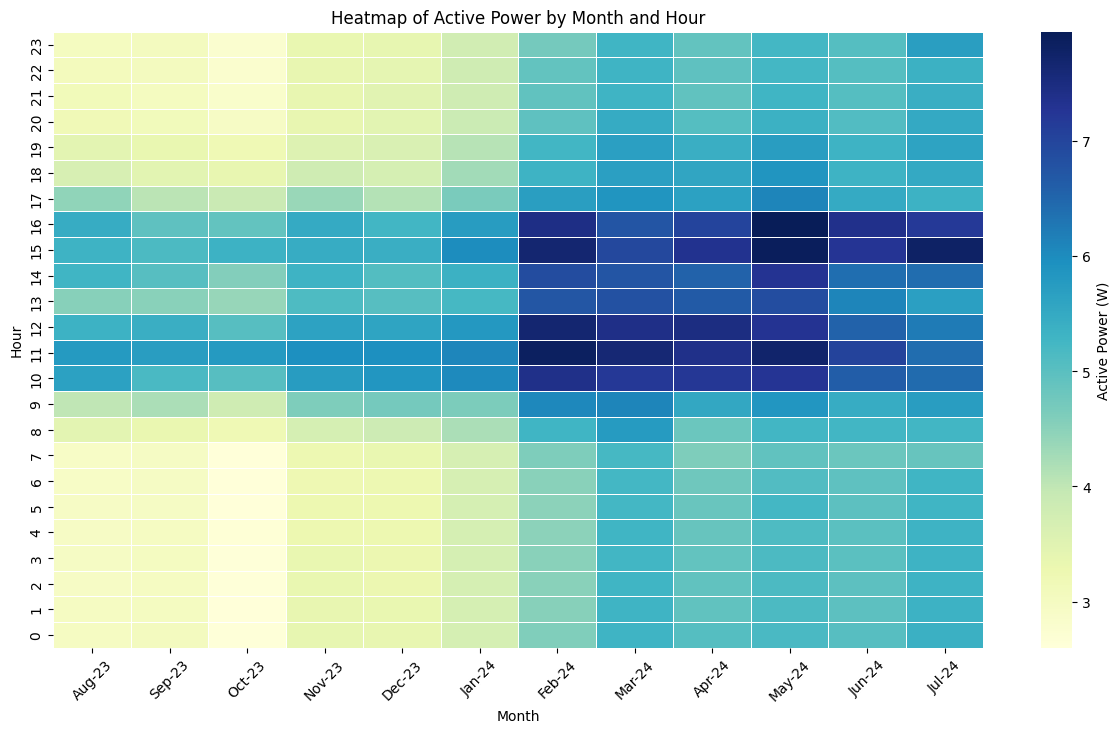

In [ ]:
# Pivot the DataFrame to get months as columns and hours as rows
heatmap_data = sm_df.pivot_table(index='Hour', columns='Month', values='Active Power', aggfunc='mean')

# Reorder the columns to have months 8-12 first, then 1-7
ordered_months = [8, 9, 10, 11, 12] + list(range(1, 8))
heatmap_data = heatmap_data.reindex(columns=ordered_months)

# Sort the index to have hours from 23 to 0
heatmap_data = heatmap_data.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt=".1f", linewidths=.5, cbar_kws={'label': 'Active Power (W)'})

# Set custom x-tick labels
center_positions = [i + 0.5 for i in range(len(ordered_months))]  # Centering adjustment
custom_labels = ['Aug-23', 'Sep-23', 'Oct-23', 'Nov-23', 'Dec-23', 
                 'Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24', 'Jun-24', 'Jul-24']

plt.xticks(ticks=center_positions, labels=custom_labels, rotation=45, ha='center')

# Set the titles and labels
plt.title('Heatmap of Active Power by Month and Hour')
plt.xlabel('Month')
plt.ylabel('Hour')

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy import stats


In [ ]:
def rosner_test(data, alpha=0.05, max_outliers=5):
    # Sort the data
    data_sorted = np.sort(data)
    n = len(data_sorted)
    
    # Calculate the mean and standard deviation
    mean = np.mean(data_sorted)
    std_dev = np.std(data_sorted, ddof=1)
    
    outliers = []
    k = 0

    while k < max_outliers:
        # Calculate the critical value
        critical_value = mean + (k + 1) * std_dev * np.sqrt((n - k) / (n - k - 1))
        
        # Identify outliers
        if data_sorted[-(k + 1)] > critical_value:
            outliers.append(data_sorted[-(k + 1)])
        else:
            break
        
        k += 1

    return outliers


In [ ]:

# Perform Rosner's test
outliers = rosner_test(sm_df['Active Power'])

# Display the outliers detected
print("Detected Outliers:", outliers)

Detected Outliers: [37.36, 29.82, 28.7, 28.580000000000002, 27.59]


In [ ]:
sm_df_cleaned = sm_df[sm_df['Active Power']<27.59]

sm_df_cleaned.shape

(49767, 10)

Text(0.5, 1.0, 'Active Power Time Series')

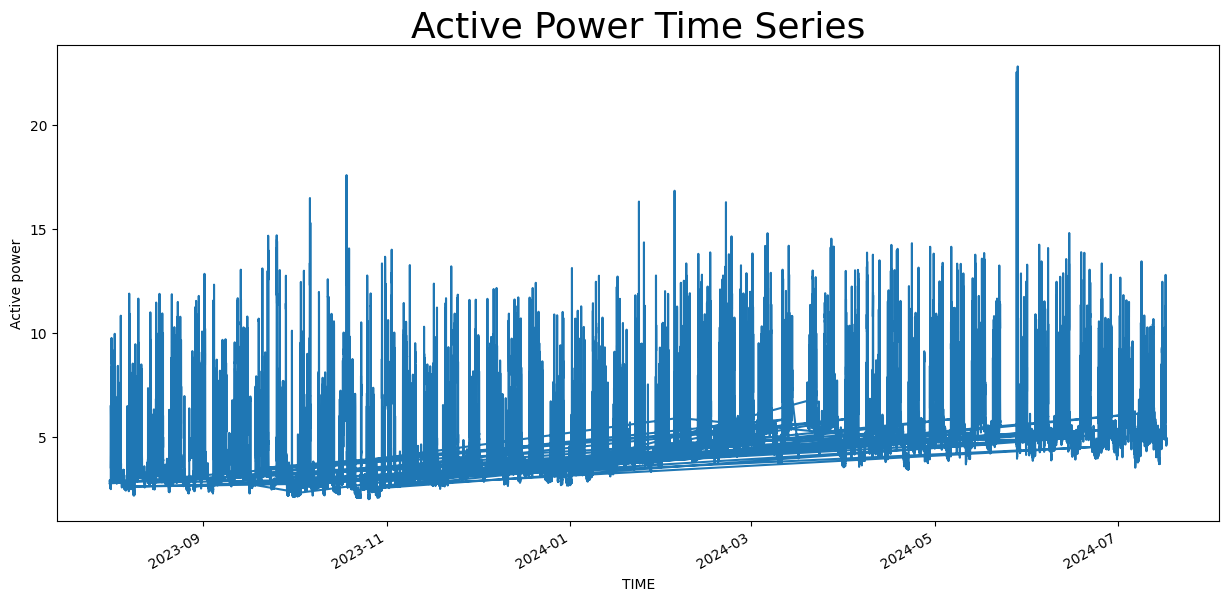

In [ ]:
sm_df_cleaned['Active Power'].plot(figsize=(15,7),legend=False)
plt.ylabel('Active power')
plt.title('Active Power Time Series',size=26)

In [ ]:

# Save the cleaned DataFrame in Feather format
sm_df_cleaned.to_feather('SM_Cleaned.feather')